# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


In [9]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
con = sqlite3.connect('data.sqlite') 
df = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 
df.shape


(103040, 12)

## [1.2] Splitting dataset into test and cv set

In [11]:
text=df['CleanedText']
label=df['Score']
from sklearn.model_selection import train_test_split
x,x_test,y,y_test=train_test_split(text,label,test_size=0.2,random_state=0, stratify=label)
x_train,x_cv,y_train,y_cv=train_test_split(x,(y,test_size=0.25, random_state=0, stratify=y)
x_train.shape

(61824,)

## [1.3] BOW, TFIDF, AVG W2V & AVG TFIDF W2V Vectorizers

In [12]:
vect=CountVectorizer().fit(x_train)
train_cnt=vect.transform(x_train)
cv_cnt=vect.transform(x_cv)
test_cnt=vect.transform(x_test)
idf=TfidfVectorizer().fit(x_train)
train_tf=idf.transform(x_train)
test_tf=idf.transform(x_test)
cv_tf=idf.transform(x_cv)

In [5]:
list_of_words=[]
for x in x_train.values:
    list_of_words.append(x.split())
    
w2v_model=Word2Vec(list_of_words, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

    
test_word_list=[]
for x in x_test.values:
    test_word_list.append(x.split())
    
cv_word_list=[]
for x in x_cv.values:
    cv_word_list.append(x.split())
    
    
train_w2v=[];
for x in tqdm(list_of_words):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v.append(sent_vec)

test_w2v=[]
for x in tqdm(test_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v.append(sent_vec)
 
cv_w2v=[]
for x in tqdm(cv_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2v.append(sent_vec)
    

100%|███████████████████████████████████| 20608/20608 [00:54<00:00, 378.57it/s]


In [20]:
model = TfidfVectorizer()
model.fit_transform(x_train.values)

dicti= dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names()

train_idf= []; 
row=0;
for sent in tqdm(list_of_words):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_idf.append(sent_vec)
    row += 1
    
tfidf_feat = model.get_feature_names() 

test_idf= []; 
row=0;
for sent in tqdm(test_word_list): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_idf.append(sent_vec)
    row += 1
    

cv_idf= []; 
row=0;
for sent in tqdm(cv_word_list): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_idf.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 20608/20608 [13:01<00:00, 26.38it/s]


### Functions for finding optimal value of K & to print Confusion Matrix

In [13]:
def hyperSearch(train,cv,y_train,y_cv):
    roc_scores=[]
    roc_t=[]
    k=list(range(1,30,2))
    for i in tqdm(k):
        knn=KNeighborsClassifier(n_neighbors=i)
        knn.fit(train,y_train)
        pred=knn.predict_proba(cv)[:,1]
        pred_train=knn.predict_proba(train)[:,1]
        roc=roc_auc_score(y_cv,pred)
        roct=roc_auc_score(y_train,pred_train)
        roc_scores.append(roc)
        roc_t.append(roct)
        xy=(i, np.round(roc,3))
        plt.annotate('(%s %s)' %xy, xy=xy, textcoords='data')
        ab=(np.round(roct),i)
        plt.annotate('(%s %s)' %ab, xy=ab, textcoords='data')
    plt.plot(k,roc_scores,'g--',label='CV data')
    plt.plot(k,roc_t,'r', label='Training data')
    plt.xlabel('Value of K')
    plt.ylabel('ROC Scores')
    plt.title('Error Plot')
    plt.legend()
    plt.show()

    
def con_mx(target1, predict1, target2, predict2):
    cm = confusion_matrix(target1, predict1)
    cm2=confusion_matrix(target2, predict2)
    cm = pd.DataFrame(cm)
    cm2 = pd.DataFrame(cm2)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm2.index.name = 'Actual'
    cm2.columns.name = 'Predicted'
    fig, (ax1,ax2)= plt.subplots(1,2)
    ax1.set_title('Training Dataset')
    ax2.set_title('Test Dataset')
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    sns.heatmap(cm2, annot=True, fmt='d', ax=ax2)



###  Function to plot ROC Curve

In [14]:
def rocPlot(test_data, train_data, y_train, y_test):
    plt.figure(1)
    #plt.subplot(111)
    pred_proba = knn.predict_proba(test_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_test, pred_proba)
    roc_auc=roc_auc_score(y_test, pred_proba)
    plt.plot(fpr, tpr, label='AUC= %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve for test data')
    plt.legend(loc="lower right")
    plt.show()
    plt.figure(2)
    pred_probat = knn.predict_proba(train_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_train, pred_probat)
    roc_auc=roc_auc_score(y_train, pred_probat)
    plt.plot(fpr, tpr, label='AUC= %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve for training data')
    plt.legend(loc="lower right")
    plt.show()

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

100%|███████████████████████████████████████| 15/15 [1:10:52<00:00, 299.74s/it]


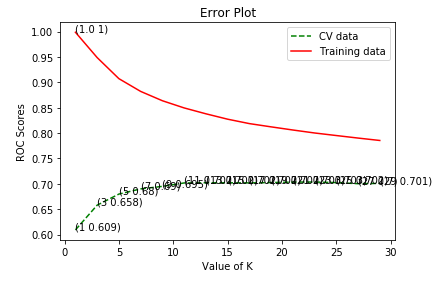

In [66]:
hyperSearch(train_cnt,cv_cnt,y_train, y_cv)

#### Fitting KNN with optimal value of K & Confusion Matrix plot

              precision    recall  f1-score   support

           0       0.48      0.14      0.21      2548
           1       0.89      0.98      0.93     18060

   micro avg       0.88      0.88      0.88     20608
   macro avg       0.69      0.56      0.57     20608
weighted avg       0.84      0.88      0.84     20608



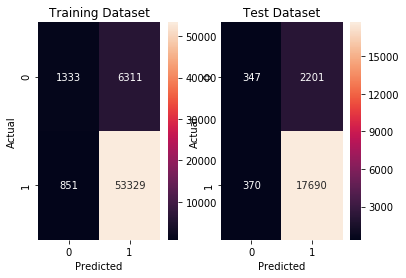

In [15]:
knn=KNeighborsClassifier(n_neighbors=11)
knn.fit(train_cnt,y_train)
predict=knn.predict(test_cnt)
pred=knn.predict(train_cnt)
con_mx(y_train,pred,y_test, predict)
print(classification_report(y_test, predict))

#### ROC Curve for training as well as test dataset

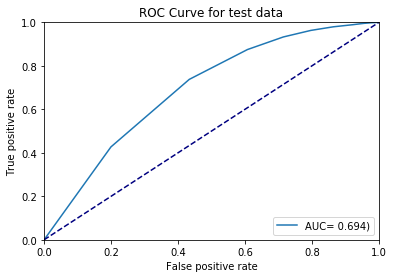

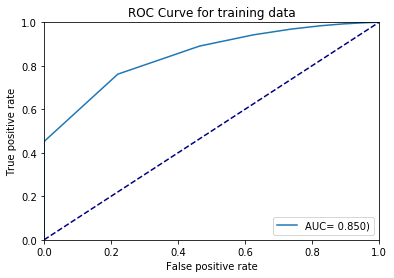

In [35]:
rocPlot(test_cnt, train_cnt, y_train, y_test)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

100%|███████████████████████████████████████| 15/15 [1:12:10<00:00, 307.32s/it]


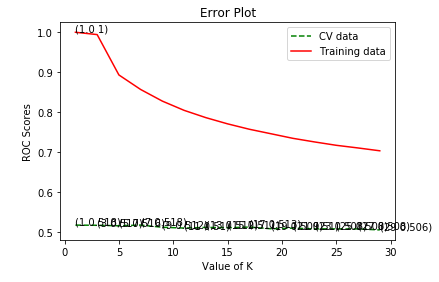

In [15]:
hyperSearch(train_tf,cv_tf,y_train, y_cv)



#### Fitting KNN with optimal value of K & Confusion Matrix plot

              precision    recall  f1-score   support

           0       0.15      0.00      0.01      2548
           1       0.88      1.00      0.93     18060

   micro avg       0.87      0.87      0.87     20608
   macro avg       0.51      0.50      0.47     20608
weighted avg       0.79      0.87      0.82     20608



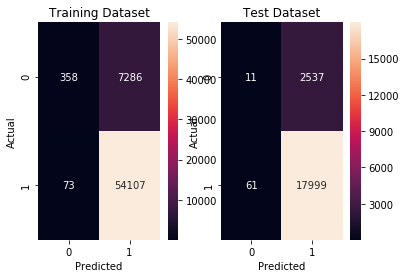

In [16]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(train_tf, y_train)
predict=knn.predict(test_tf)
pred=knn.predict(train_tf)
con_mx(y_train,pred,y_test, predict)
print(classification_report(y_test, predict))

#### ROC Curve for training as well as test dataset

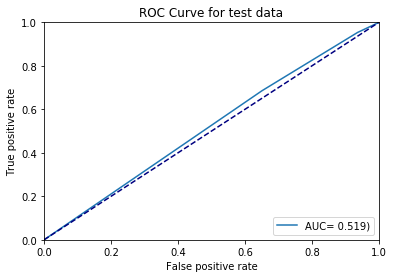

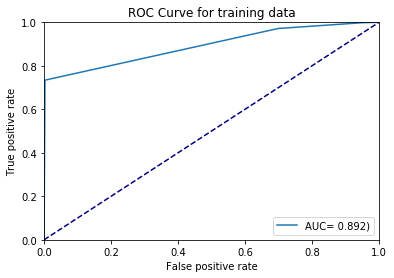

In [17]:
rocPlot(test_tf, train_tf, y_train, y_test)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

100%|██████████████████████████████████████| 15/15 [5:58:45<00:00, 1583.33s/it]


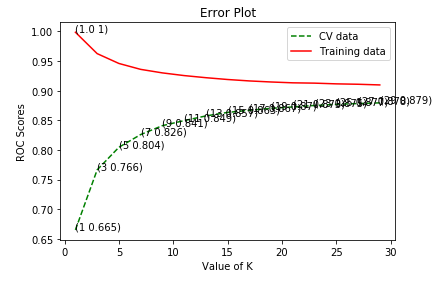

In [12]:
hyperSearch(train_w2v,cv_w2v,y_train, y_cv)



#### Fitting KNN with optimal value of K & Confusion Matrix plot

              precision    recall  f1-score   support

           0       0.74      0.25      0.37      2548
           1       0.90      0.99      0.94     18060

   micro avg       0.90      0.90      0.90     20608
   macro avg       0.82      0.62      0.66     20608
weighted avg       0.88      0.90      0.87     20608



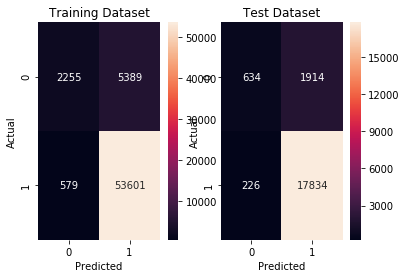

In [18]:
knn=KNeighborsClassifier(n_neighbors=15)
knn.fit(train_w2v, y_train)
predict=knn.predict(test_w2v)
pred=knn.predict(train_w2v)
con_mx(y_train,pred,y_test, predict)
print(classification_report(y_test, predict))

#### ROC Curve for training as well as test dataset

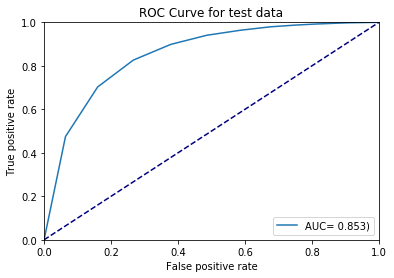

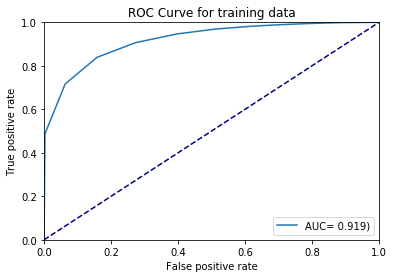

In [19]:
rocPlot(test_w2v, train_w2v, y_train, y_test)

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

100%|███████████████████████████████████████| 15/15 [3:00:49<00:00, 790.33s/it]


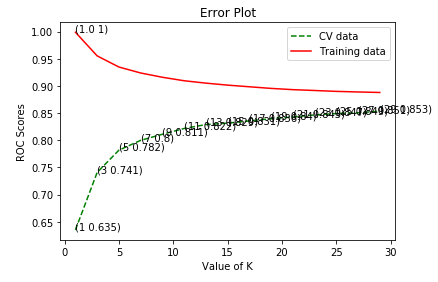

In [12]:
hyperSearch(train_idf,cv_idf,y_train, y_cv)


#### Fitting KNN with optimal value of K & Confusion Matrix plot

              precision    recall  f1-score   support

           0       0.69      0.21      0.32      2548
           1       0.90      0.99      0.94     18060

   micro avg       0.89      0.89      0.89     20608
   macro avg       0.79      0.60      0.63     20608
weighted avg       0.87      0.89      0.86     20608



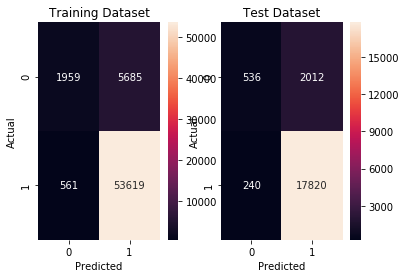

In [21]:
knn=KNeighborsClassifier(n_neighbors=13)
knn.fit(train_idf, y_train)
predict=knn.predict(test_idf)
pred=knn.predict(train_idf)
con_mx(y_train,pred,y_test, predict)
print(classification_report(y_test, predict))

#### ROC Curve for training as well as test dataset

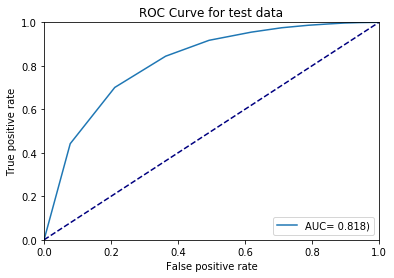

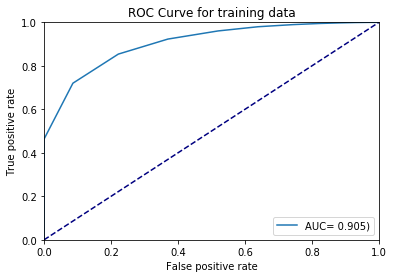

In [22]:
rocPlot(test_idf, train_idf, y_train, y_test)

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [23]:
vec=CountVectorizer(min_df=10, max_features=500)
cnt=vec.fit(x_train)
train_kd=cnt.transform(x_train)
test_kd=cnt.transform(x_test)
cv_kd=cnt.transform(x_cv)
train_dense=train_kd.toarray()
test_dense=test_kd.toarray()
cv_dense=cv_kd.toarray()

df=TfidfVectorizer(min_df=10, max_features=500)
dft=df.fit(x_train)
train_id=dft.transform(x_train)
test_id=dft.transform(x_test)
cv_id=dft.transform(x_cv)
train_dfa=train_id.toarray()
test_dfa=test_id.toarray()
cv_dfa=cv_id.toarray()


    

Since, kd-tree takes much longer time for training, so limiting features to 500 and vectorizing dataset for BOW & TFIDF.

#### To find optimal value of K for BOW(Kdtree)

100%|█████████████████████████████████████| 10/10 [16:06:21<00:00, 5800.12s/it]


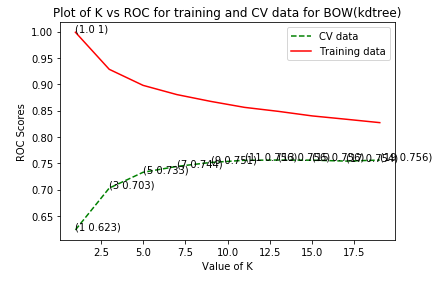

Wall time: 16h 6min 21s


In [6]:
%%time
roc_scores=[]
roc_t=[]
k=list(range(1,20,2))
for i in tqdm(k):
    knn=KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    knn.fit(train_dense,y_train)
    predd=knn.predict_proba(cv_dense)[:,1]
    pred_traind=knn.predict_proba(train_dense)[:,1]
    roc=roc_auc_score(y_cv,predd)
    roct=roc_auc_score(y_train,pred_traind)
    roc_scores.append(roc)
    roc_t.append(roct)
    xy=(i, np.round(roc,3))
    plt.annotate('(%s %s)' %xy, xy=xy, textcoords='data')
    ab=(np.round(roct),i)
    plt.annotate('(%s %s)' %ab, xy=ab, textcoords='data')
plt.plot(k,roc_scores,'g--',label='CV data')
plt.plot(k,roc_t,'r', label='Training data')
plt.xlabel('Value of K')
plt.ylabel('ROC Scores')
plt.title('Plot of K vs ROC for training and CV data for BOW(kdtree)')
plt.legend()
plt.show()
    

#### Fitting KNN with optimal value of K & Confusion Matrix plot

              precision    recall  f1-score   support

           0       0.43      0.26      0.33      2548
           1       0.90      0.95      0.93     18060

   micro avg       0.87      0.87      0.87     20608
   macro avg       0.66      0.61      0.63     20608
weighted avg       0.84      0.87      0.85     20608



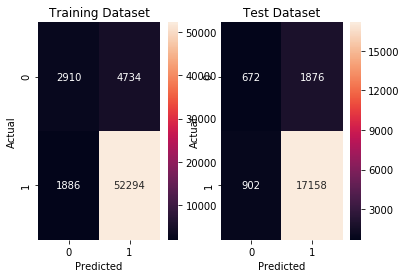

In [9]:
knn=KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
knn.fit(train_dense, y_train)
pred=knn.predict(test_dense)
preda=knn.predict(train_dense)
con_mx(y_train,preda,y_test, pred)
print(classification_report(y_test, pred))

#### ROC Curve for training as well as test dataset

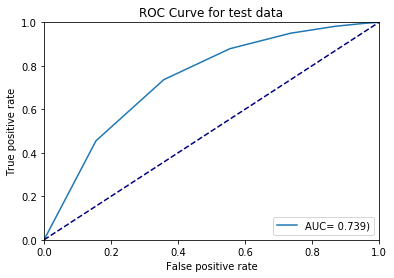

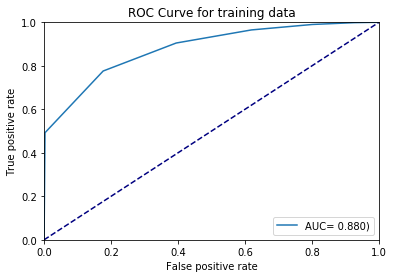

In [10]:
rocPlot(test_dense, train_dense, y_train, y_test)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

#### To find optimal value of K for TFIDF(Kdtree)

100%|███████████████████████████████████████| 8/8 [12:27:17<00:00, 5724.13s/it]


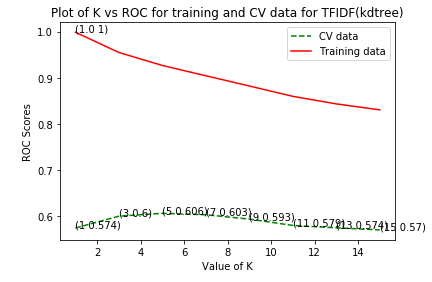

Wall time: 12h 27min 17s


In [8]:
%%time
roc_scores=[]
roc_t=[]
k=list(range(1,16,2))
for i in tqdm(k):
    knn=KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    knn.fit(train_df,y_train)
    predd=knn.predict_proba(cv_df)[:,1]
    pred_traind=knn.predict_proba(train_df)[:,1]
    roc=roc_auc_score(y_cv,predd)
    roct=roc_auc_score(y_train,pred_traind)
    roc_scores.append(roc)
    roc_t.append(roct)
    xy=(i, np.round(roc,3))
    plt.annotate('(%s %s)' %xy, xy=xy, textcoords='data')
    ab=(np.round(roct),i)
    plt.annotate('(%s %s)' %ab, xy=ab, textcoords='data')
plt.plot(k,roc_scores,'g--',label='CV data')
plt.plot(k,roc_t,'r', label='Training data')
plt.xlabel('Value of K')
plt.ylabel('ROC Scores')
plt.title('Plot of K vs ROC for training and CV data for TFIDF(kdtree)')
plt.legend()
plt.show()
    

#### Fitting KNN with optimal value of K & Confusion Matrix plot

              precision    recall  f1-score   support

           0       0.61      0.05      0.09      2548
           1       0.88      1.00      0.93     18060

   micro avg       0.88      0.88      0.88     20608
   macro avg       0.74      0.52      0.51     20608
weighted avg       0.85      0.88      0.83     20608



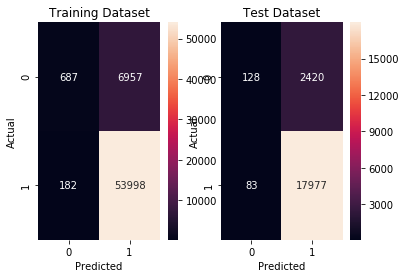

In [24]:
knn=KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
knn.fit(train_dfa, y_train)
pred=knn.predict(test_dfa)
preda=knn.predict(train_dfa)
con_mx(y_train,preda,y_test, pred)
print(classification_report(y_test, pred))

#### ROC Curve for training as well as test dataset

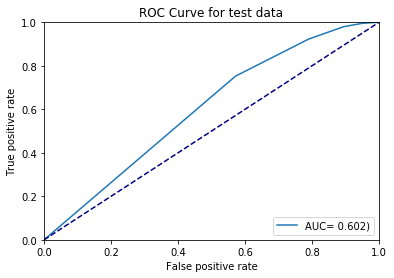

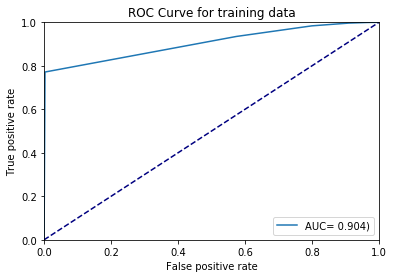

In [25]:
rocPlot(test_dfa, train_dfa, y_train, y_test)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

#### To find optimal value of K for AVG W2V(Kdtree)

100%|██████████████████████████████████████| 10/10 [2:45:36<00:00, 1108.77s/it]


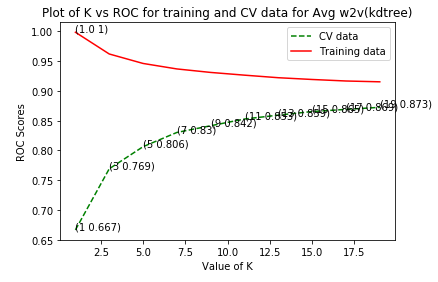

Wall time: 2h 45min 36s


In [10]:
%%time
roc_scores=[]
roc_t=[]
k=list(range(1,20,2))
for i in tqdm(k):
    knn=KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    knn.fit(train_w2v,y_train)
    predd=knn.predict_proba(cv_w2v)[:,1]
    pred_traind=knn.predict_proba(train_w2v)[:,1]
    roc=roc_auc_score(y_cv,predd)
    roct=roc_auc_score(y_train,pred_traind)
    roc_scores.append(roc)
    roc_t.append(roct)
    xy=(i, np.round(roc,3))
    plt.annotate('(%s %s)' %xy, xy=xy, textcoords='data')
    ab=(np.round(roct),i)
    plt.annotate('(%s %s)' %ab, xy=ab, textcoords='data')
plt.plot(k,roc_scores,'g--',label='CV data')
plt.plot(k,roc_t,'r', label='Training data')
plt.xlabel('Value of K')
plt.ylabel('ROC Scores')
plt.title('Plot of K vs ROC for training and CV data for Avg w2v(kdtree)')
plt.legend()
plt.show()
    

#### Fitting KNN with optimal value of K & Confusion Matrix plot

              precision    recall  f1-score   support

           0       0.68      0.27      0.39      2548
           1       0.91      0.98      0.94     18060

   micro avg       0.89      0.89      0.89     20608
   macro avg       0.79      0.63      0.67     20608
weighted avg       0.88      0.89      0.87     20608



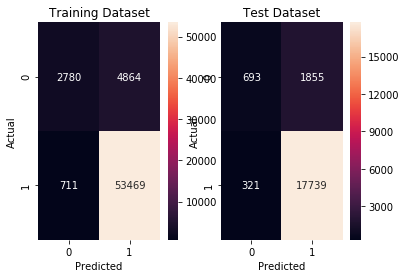

In [13]:
knn=KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree')
knn.fit(train_w2v, y_train)
pred=knn.predict(test_w2v)
preda=knn.predict(train_w2v)
con_mx(y_train,preda,y_test, pred)
print(classification_report(y_test, pred))

#### ROC Curve for training as well as test dataset

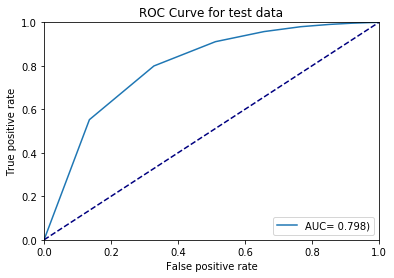

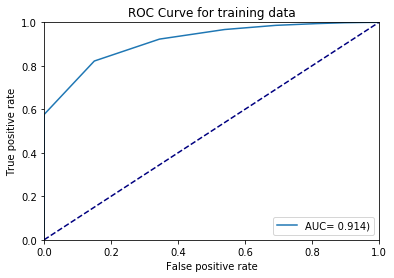

In [25]:
rocPlot(test_w2v, train_w2v, y_train, y_test)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

#### To find optimal value of K for TFIDF W2V(Kdtree)

100%|█████████████████████████████████████████| 8/8 [1:25:47<00:00, 685.35s/it]


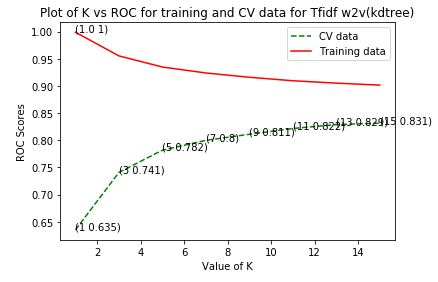

Wall time: 1h 25min 47s


In [13]:
%%time
roc_scores=[]
roc_t=[]
k=list(range(1,16,2))
for i in tqdm(k):
    knn=KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    knn.fit(train_idf,y_train)
    predd=knn.predict_proba(cv_idf)[:,1]
    pred_traind=knn.predict_proba(train_idf)[:,1]
    roc=roc_auc_score(y_cv,predd)
    roct=roc_auc_score(y_train,pred_traind)
    roc_scores.append(roc)
    roc_t.append(roct)
    xy=(i, np.round(roc,3))
    plt.annotate('(%s %s)' %xy, xy=xy, textcoords='data')
    ab=(np.round(roct),i)
    plt.annotate('(%s %s)' %ab, xy=ab, textcoords='data')
plt.plot(k,roc_scores,'g--',label='CV data')
plt.plot(k,roc_t,'r', label='Training data')
plt.xlabel('Value of K')
plt.ylabel('ROC Scores')
plt.title('Plot of K vs ROC for training and CV data for Tfidf w2v(kdtree)')
plt.legend()
plt.show()
    

#### Fitting KNN with optimal value of K & Confusion Matrix plot

              precision    recall  f1-score   support

           0       0.66      0.23      0.34      2548
           1       0.90      0.98      0.94     18060

   micro avg       0.89      0.89      0.89     20608
   macro avg       0.78      0.61      0.64     20608
weighted avg       0.87      0.89      0.87     20608



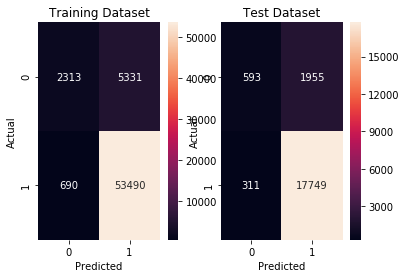

In [11]:
knn=KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree')
knn.fit(train_idf, y_train)
pred=knn.predict(test_idf)
preda=knn.predict(train_idf)
con_mx(y_train,preda,y_test, pred)
print(classification_report(y_test, pred))

#### ROC Curve for training as well as test dataset

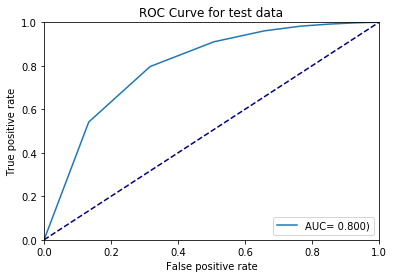

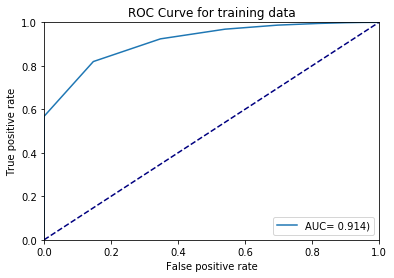

In [12]:
rocPlot(test_idf, train_idf, y_train, y_test)

# [6] Conclusions

In [26]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Vectorizer", "Model", "Hyper Parameter", "AUC"]
x.add_row(["BOW", "Brute", 11, 0.694])
x.add_row(["TF-IDF","Brute", 5, 0.519])
x.add_row(["BOW", "Kdtree", 7, 0.739])
x.add_row(["TF-IDF", "Kdtree", 7, 0.602])
x.add_row(["AVG W2V", "BRUTE", 15, 0.853])
x.add_row(["TFIDF W2V", "BRUTE", 13, 0.818])
x.add_row(["AVG W2V", "Kdtree",9 , 0.798])
x.add_row(["TFIDF W2V", "Kdtree", 9, 0.800])
print(x)

+------------+--------+-----------------+-------+
| Vectorizer | Model  | Hyper Parameter |  AUC  |
+------------+--------+-----------------+-------+
|    BOW     | Brute  |        11       | 0.694 |
|   TF-IDF   | Brute  |        5        | 0.519 |
|    BOW     | Kdtree |        7        | 0.739 |
|   TF-IDF   | Kdtree |        7        | 0.602 |
|  AVG W2V   | BRUTE  |        15       | 0.853 |
| TFIDF W2V  | BRUTE  |        13       | 0.818 |
|  AVG W2V   | Kdtree |        9        | 0.798 |
| TFIDF W2V  | Kdtree |        9        |  0.8  |
+------------+--------+-----------------+-------+
